# Figure 4: Nature of non- trans-spliced messengers

**Summary:**

This notebook compiles the scripts that were used to generate the Figure 4.

- **Panel a:** Gene expression and trans-splicing status.

- **Panel b:** Trans-splicing detection level

- **Panel c:** Poorly trans spliced mRNA have a propensity to form a 5’ stem loop structure

---
<br>



## Import libraries

In [1]:
import pandas as pd
import seaborn as sns
import pyranges as pr
import matplotlib as mpl
import matplotlib.pyplot as plt
from upsetplot import plot

## Settings for saving figures as pdf

In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

## Opening Dataset file

In [3]:
# Open dataset generated as part of the pre-processing step

dataset = pd.read_csv('dataset_+SL_+hairpin.tsv', sep='\t')

In [4]:
# open file generated as part of the pre-processing step (see part 3)

genes_start = pd.read_csv('SL_&_mimic_positions.tsv', sep='\t')

----

<br>

# Panel a: Gene expression and trans-splicing status

In [5]:
# load GTF file from WS270 release
WS270_gtf = pr.read_gtf('/Volumes/elegans/rna_sequencing/ref/c_elegans.PRJNA13758.WS270.canonical_geneset.gtf')
WS270_gtf = WS270_gtf.df

# Select protein coding entries
WS270_coding_genes = list(WS270_gtf[(WS270_gtf['gene_biotype']=='protein_coding') & (WS270_gtf['Feature']=='gene')]['gene_id'])

In [6]:
# ONT dataset (This paper)

ONT = pd.DataFrame()
idx=0
for gene, reads in dataset.groupby('gene'):
    
    ONT.loc[idx,'gene'] = gene
    ONT.loc[idx,'reads'] = int(len(reads))
    
    if len(reads[(reads['SL'].notna()) | (reads['softclip']==1)]) > 0:
        ONT.loc[idx,'trans-splicing'] = True
    else:
        ONT.loc[idx,'trans-splicing'] = False
    
    idx = idx+1

# convert name to wormbase ID
WS270_ref = pd.read_csv('/Volumes/elegans/rna_sequencing/ref/genes_coordinates.tsv', sep='\t')
ONT_to_WB = WS270_ref.set_index('CDS')['wormbaseID'].to_dict()
ONT['wormbaseID'] = ONT['gene'].map(ONT_to_WB)

In [7]:
# Illumina dataset  (from Tourasse et al, 2019)

illumina = pd.read_csv('/Volumes/elegans/rna_sequencing/ref/supp_gr.224626.117_Supplemental_Table_S4_SL_junctions.txt', sep='\t')

# convert name to wormbase ID (uses WS251 release)
ws251 = pd.read_csv('/Volumes/elegans/rna_sequencing/ref/c_elegans.PRJNA13758.WS251.geneIDs.txt', header=None)
ws251.columns = ['index','wormbaseID','name','CDS','status']
current_to_WB = ws251.set_index('name')['wormbaseID'].to_dict()

# CDS names to wormbase ID
CDS_to_WB = ws251.set_index('CDS')['wormbaseID'].to_dict()


def illumina_to_wormbase(gene_name):
    
    if gene_name in current_to_WB:
        return current_to_WB[gene_name]
    
    elif gene_name in CDS_to_WB:
        return CDS_to_WB[gene_name]
    
    else:
        return None

# run
illumina['wormbaseID'] =  illumina['gene'].apply(illumina_to_wormbase)


In [8]:
# Merge ONT and ILLUMINA sets

ONT_found = list(set(ONT[ONT['trans-splicing'] == True]['wormbaseID']))

ILLUMINA_found = list(set(illumina['wormbaseID']))

def TS_categories(gene):
    
    if gene in ONT_found and gene in ILLUMINA_found:
        return 'BOTH'
    
    elif gene in ONT_found :
        return 'ONT'
    
    elif gene in ILLUMINA_found:
        return 'ILLUMINA'
    
    else:
        return 'NONE'

    
# create dataframe
cross = pd.DataFrame({'gene': WS270_coding_genes})

# find result
cross['set'] = cross['gene'].apply(TS_categories)

cross['ONT'] = cross['gene'].apply(lambda x: True if x in ONT_found else False)
cross['ILLUMINA'] = cross['gene'].apply(lambda x: True if x in ILLUMINA_found else False)

cross = pd.concat([cross.set_index('gene'), ONT.set_index('wormbaseID')], axis=1)

In [9]:
cross

,set,ONT,ILLUMINA,gene,reads,trans-splicing
WBGene00022276,BOTH,True,True,Y74C9A.2,3753.0,True
WBGene00022275,BOTH,True,True,Y74C9A.1,4.0,True
WBGene00044345,BOTH,True,True,Y48G1C.12,163.0,True
WBGene00021677,BOTH,True,True,Y48G1C.4,83.0,True
WBGene00000812,BOTH,True,True,Y48G1C.2,74.0,True
...,...,...,...,...,...,...
WBGene00018192,BOTH,True,True,F39B3.3,4.0,True
WBGene00015868,BOTH,True,True,C16H3.3,31.0,True
WBGene00019211,BOTH,True,True,H18N23.2,169.0,True
WBGene00044772,BOTH,True,True,T23E7.6,134.0,True


In [10]:
# looking solely at genes found in our dataset
ont_expr = cross[cross['reads']>0]

# generate and count categories

_BOTH = len(ont_expr[(ont_expr['ILLUMINA']==True)&(ont_expr['ONT']==True)])
print(f'Genes found trans-spliced in both datasets: {_BOTH}')

_ONT = len(ont_expr[(ont_expr['ILLUMINA']==False)&(ont_expr['ONT']==True)])
print(f'Genes found trans-spliced in ONT dataset only: {_ONT}')

_ILLUMINA = len(ont_expr[(ont_expr['ILLUMINA']==True)&(ont_expr['ONT']==False)])
print(f'Genes found trans-spliced in Illumina dataset only: {_ILLUMINA}')

_NONE = len(ont_expr[(ont_expr['ILLUMINA']==False)&(ont_expr['ONT']==False)])
print(f'Genes not found trans-spliced in either dataset: {_NONE}')

Genes found trans-spliced in both datasets: 16233
Genes found trans-spliced in ONT dataset only: 1519
Genes found trans-spliced in Illumina dataset only: 161
Genes not found trans-spliced in either dataset: 107


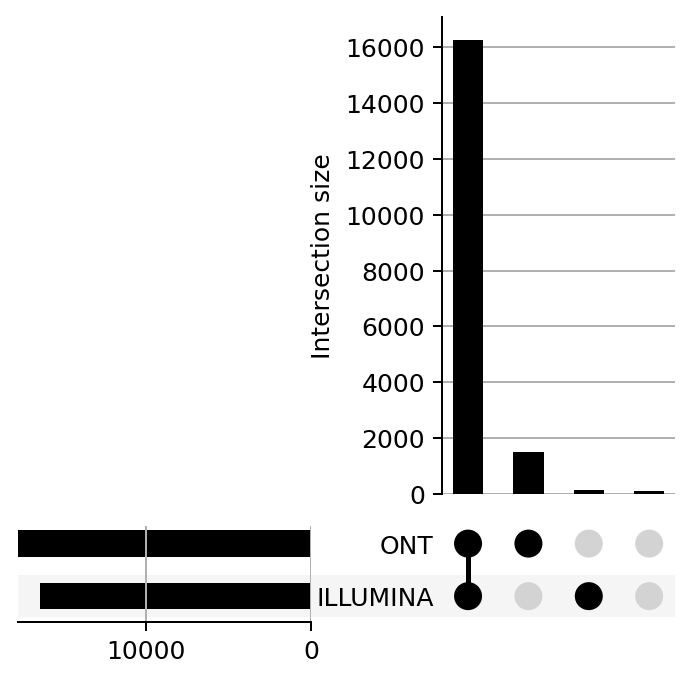

In [11]:
# Count genes per set
upset_cat = ont_expr.groupby(['ILLUMINA','ONT']).size()

# Show upset plot
p = plot(upset_cat, fig=plt.figure(figsize=(8,8), dpi=180), sort_categories_by=None, facecolor='k', sort_by='cardinality', totals_plot_elements=5, intersection_plot_elements=8)

# Save plot
plt.savefig('Fig4.a-upset_plot.pdf', dpi=800, bbox_inches='tight')

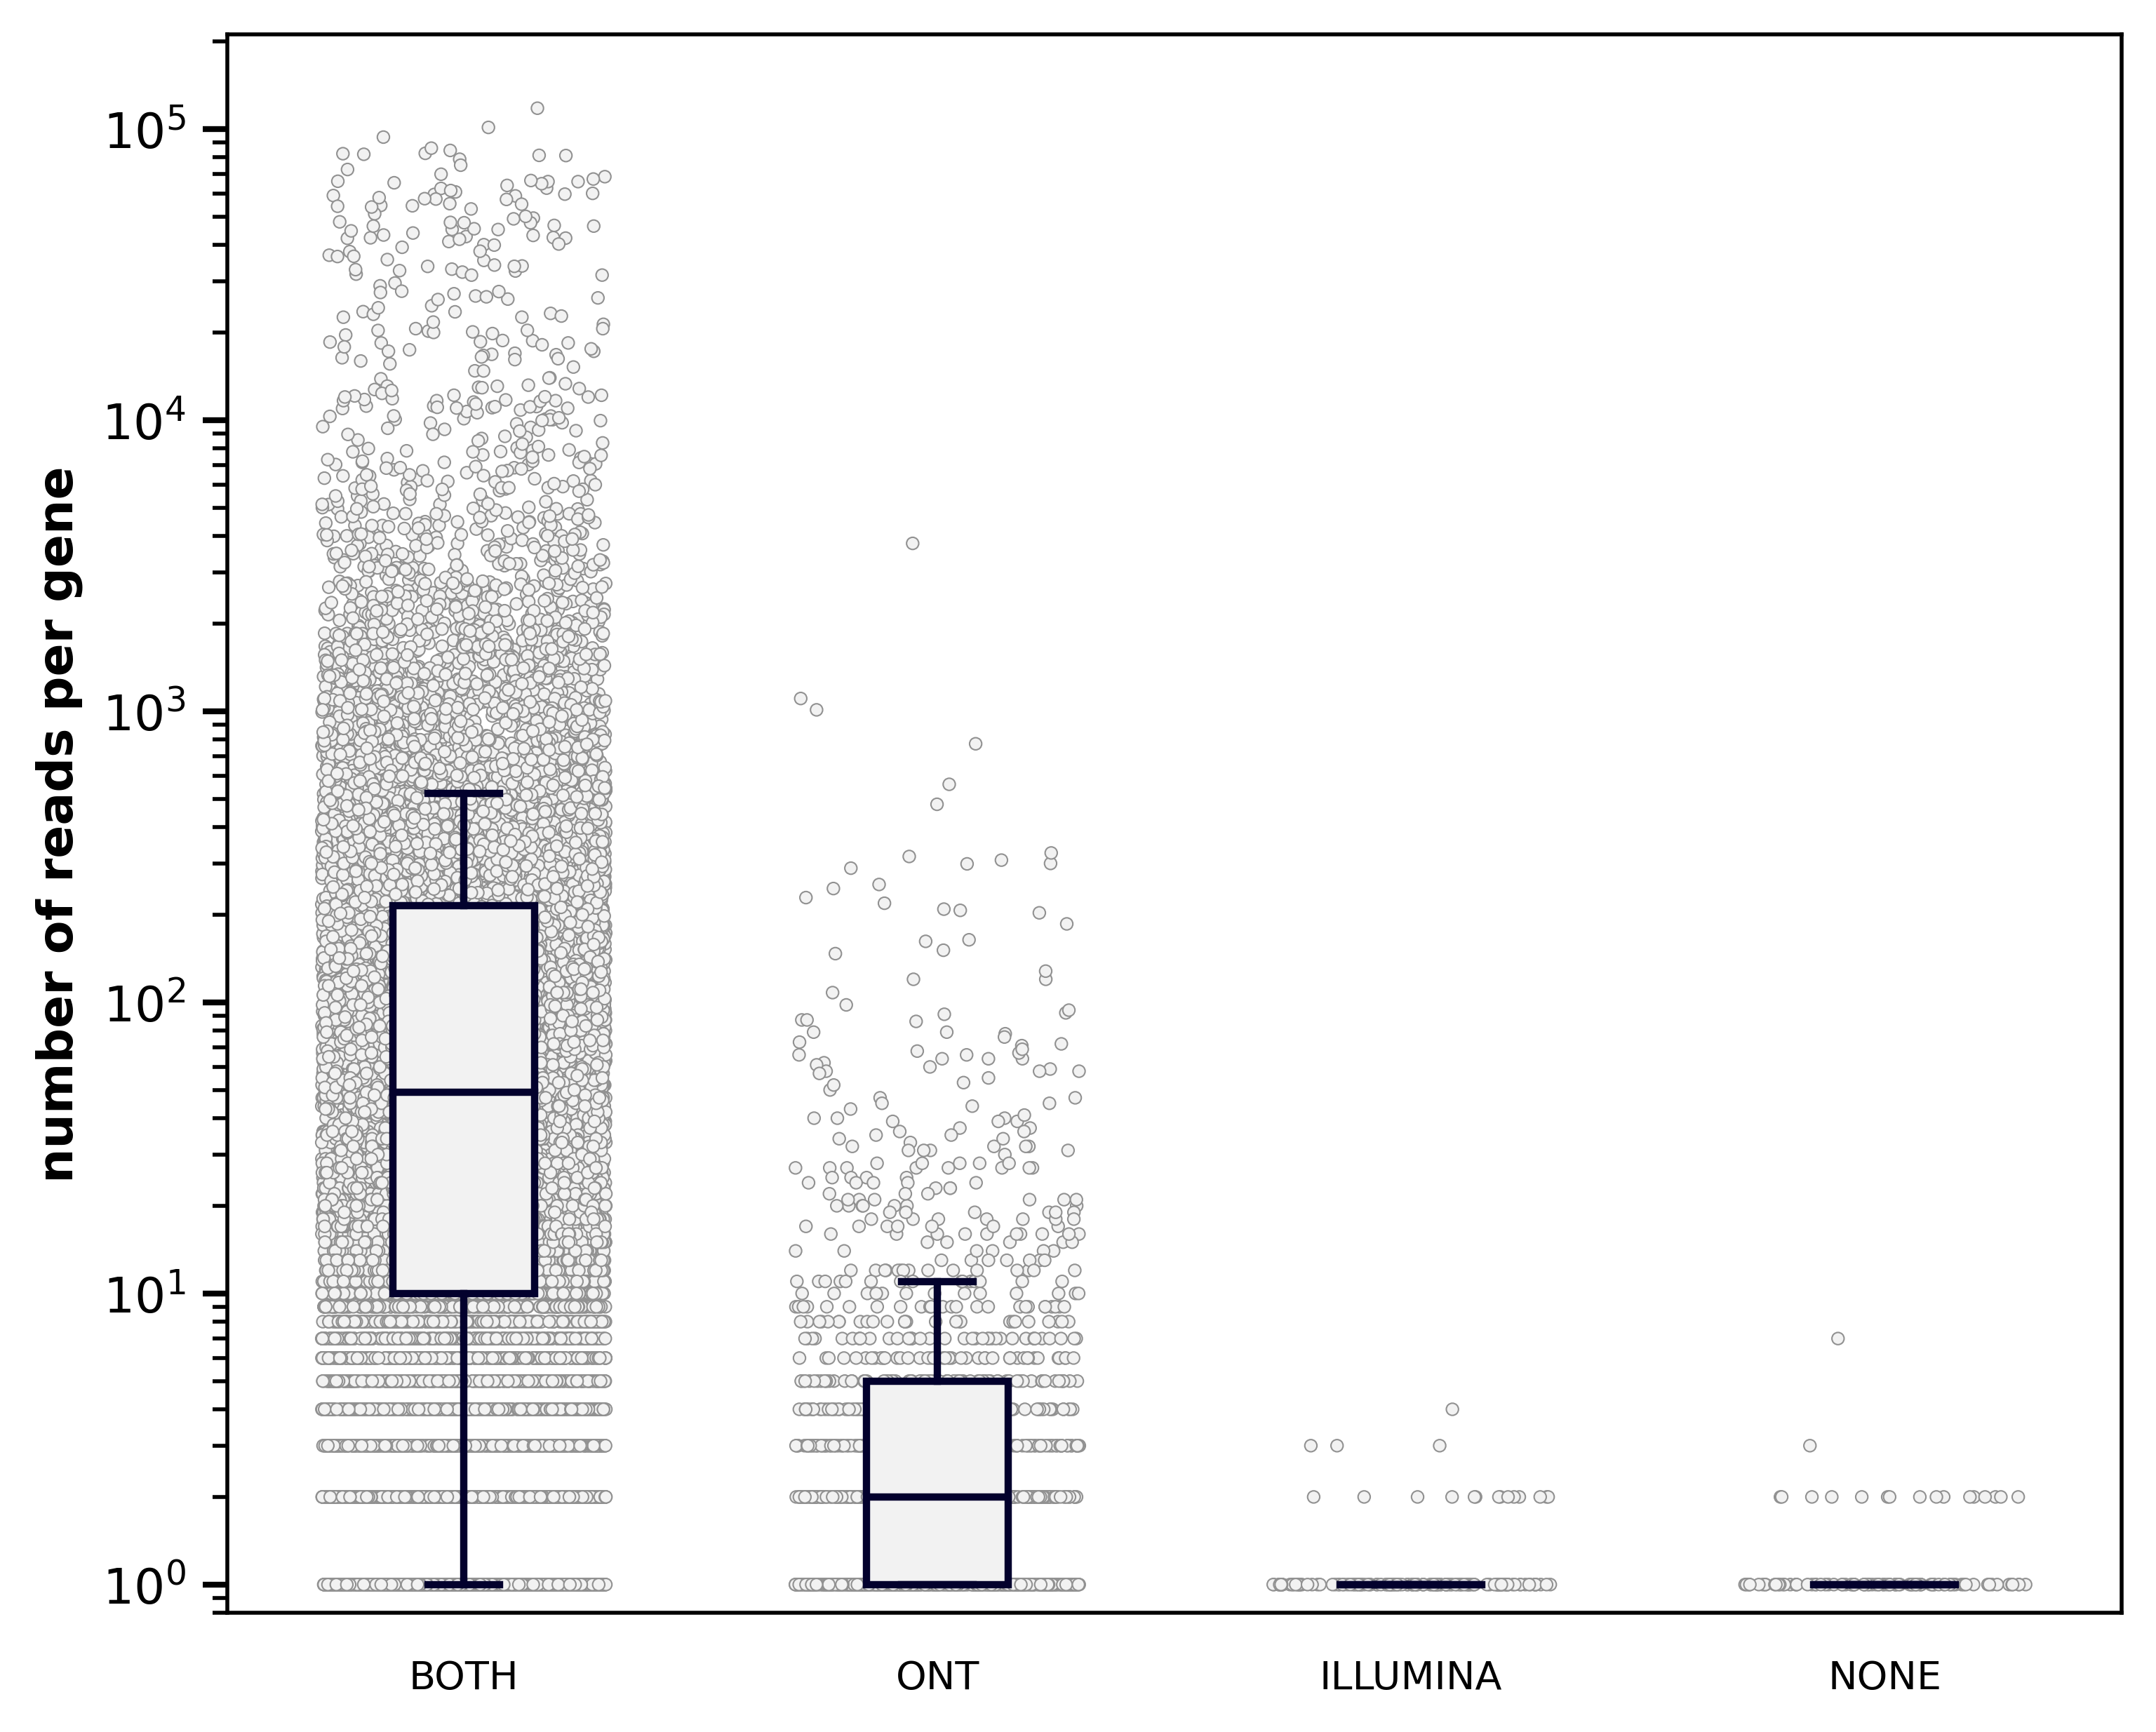

<Figure size 432x288 with 0 Axes>

In [12]:
# create figure
%matplotlib inline
fig = plt.figure(figsize=(6, 5), dpi=500)

# create a rectangle for the new axis
rect = 0.1 ,0.1, 0.9, 0.9

# create a new axis
log_ax = fig.add_axes(rect)

# log first
log_ax.set_yscale("log")

# Stripplot
col = ['#f2f2f2','#f2f2f2','#f2f2f2','#f2f2f2']
ax = sns.stripplot(x='set', y='reads', data=ont_expr, palette=col, linewidth=0.3, jitter=0.3, size=2.5, alpha=1, zorder=0)

# Boxplot
PROPS = {'boxprops':{'edgecolor':'#03012d'},'medianprops':{'color':'#03012d'},'whiskerprops':{'color':'#03012d'},'capprops':{'color':'#03012d'}}
sns.boxplot(x='set', y='reads', data=ont_expr, fliersize=0, palette=col, width=0.3, zorder=1, **PROPS )

# Plot settings
log_ax.tick_params(direction='out', length=6, width=2, colors='black', grid_alpha=0.5, bottom=False, left=False)
log_ax.set_ylim(bottom= 0.8)
log_ax.tick_params(axis='y', which ='minor', direction='out', length=3, width=0.8, colors='black', grid_alpha=0.5, left=True)
log_ax.tick_params(axis='y', which ='major', direction='out', length=5, width=1.2, colors='black', grid_alpha=0.5, left=True)

plt.xticks(size=8)
plt.xlabel('')
plt.ylabel('number of reads per gene', weight='bold')

plt.show()

# save
plt.savefig('Fig4.a-gene_expression_by_sets.png', dpi=800, bbox_inches='tight')

<br>

<font size="4">**Figure 4.a:**<br></font>
Gene expression and trans splicing status. We grouped gene in the C. elegans genome for which a direct cDNA read was obtained in this study according to the presence of evidence of trans splicing in this study and/or in the compendium of RNA-seq we previously analysed (Tourasse, 2017). For each gene we plotted the number of Nanopore reads we obtained as a proxy for gene expression level.

<br>

# Panel b: Trans-splicing detection level

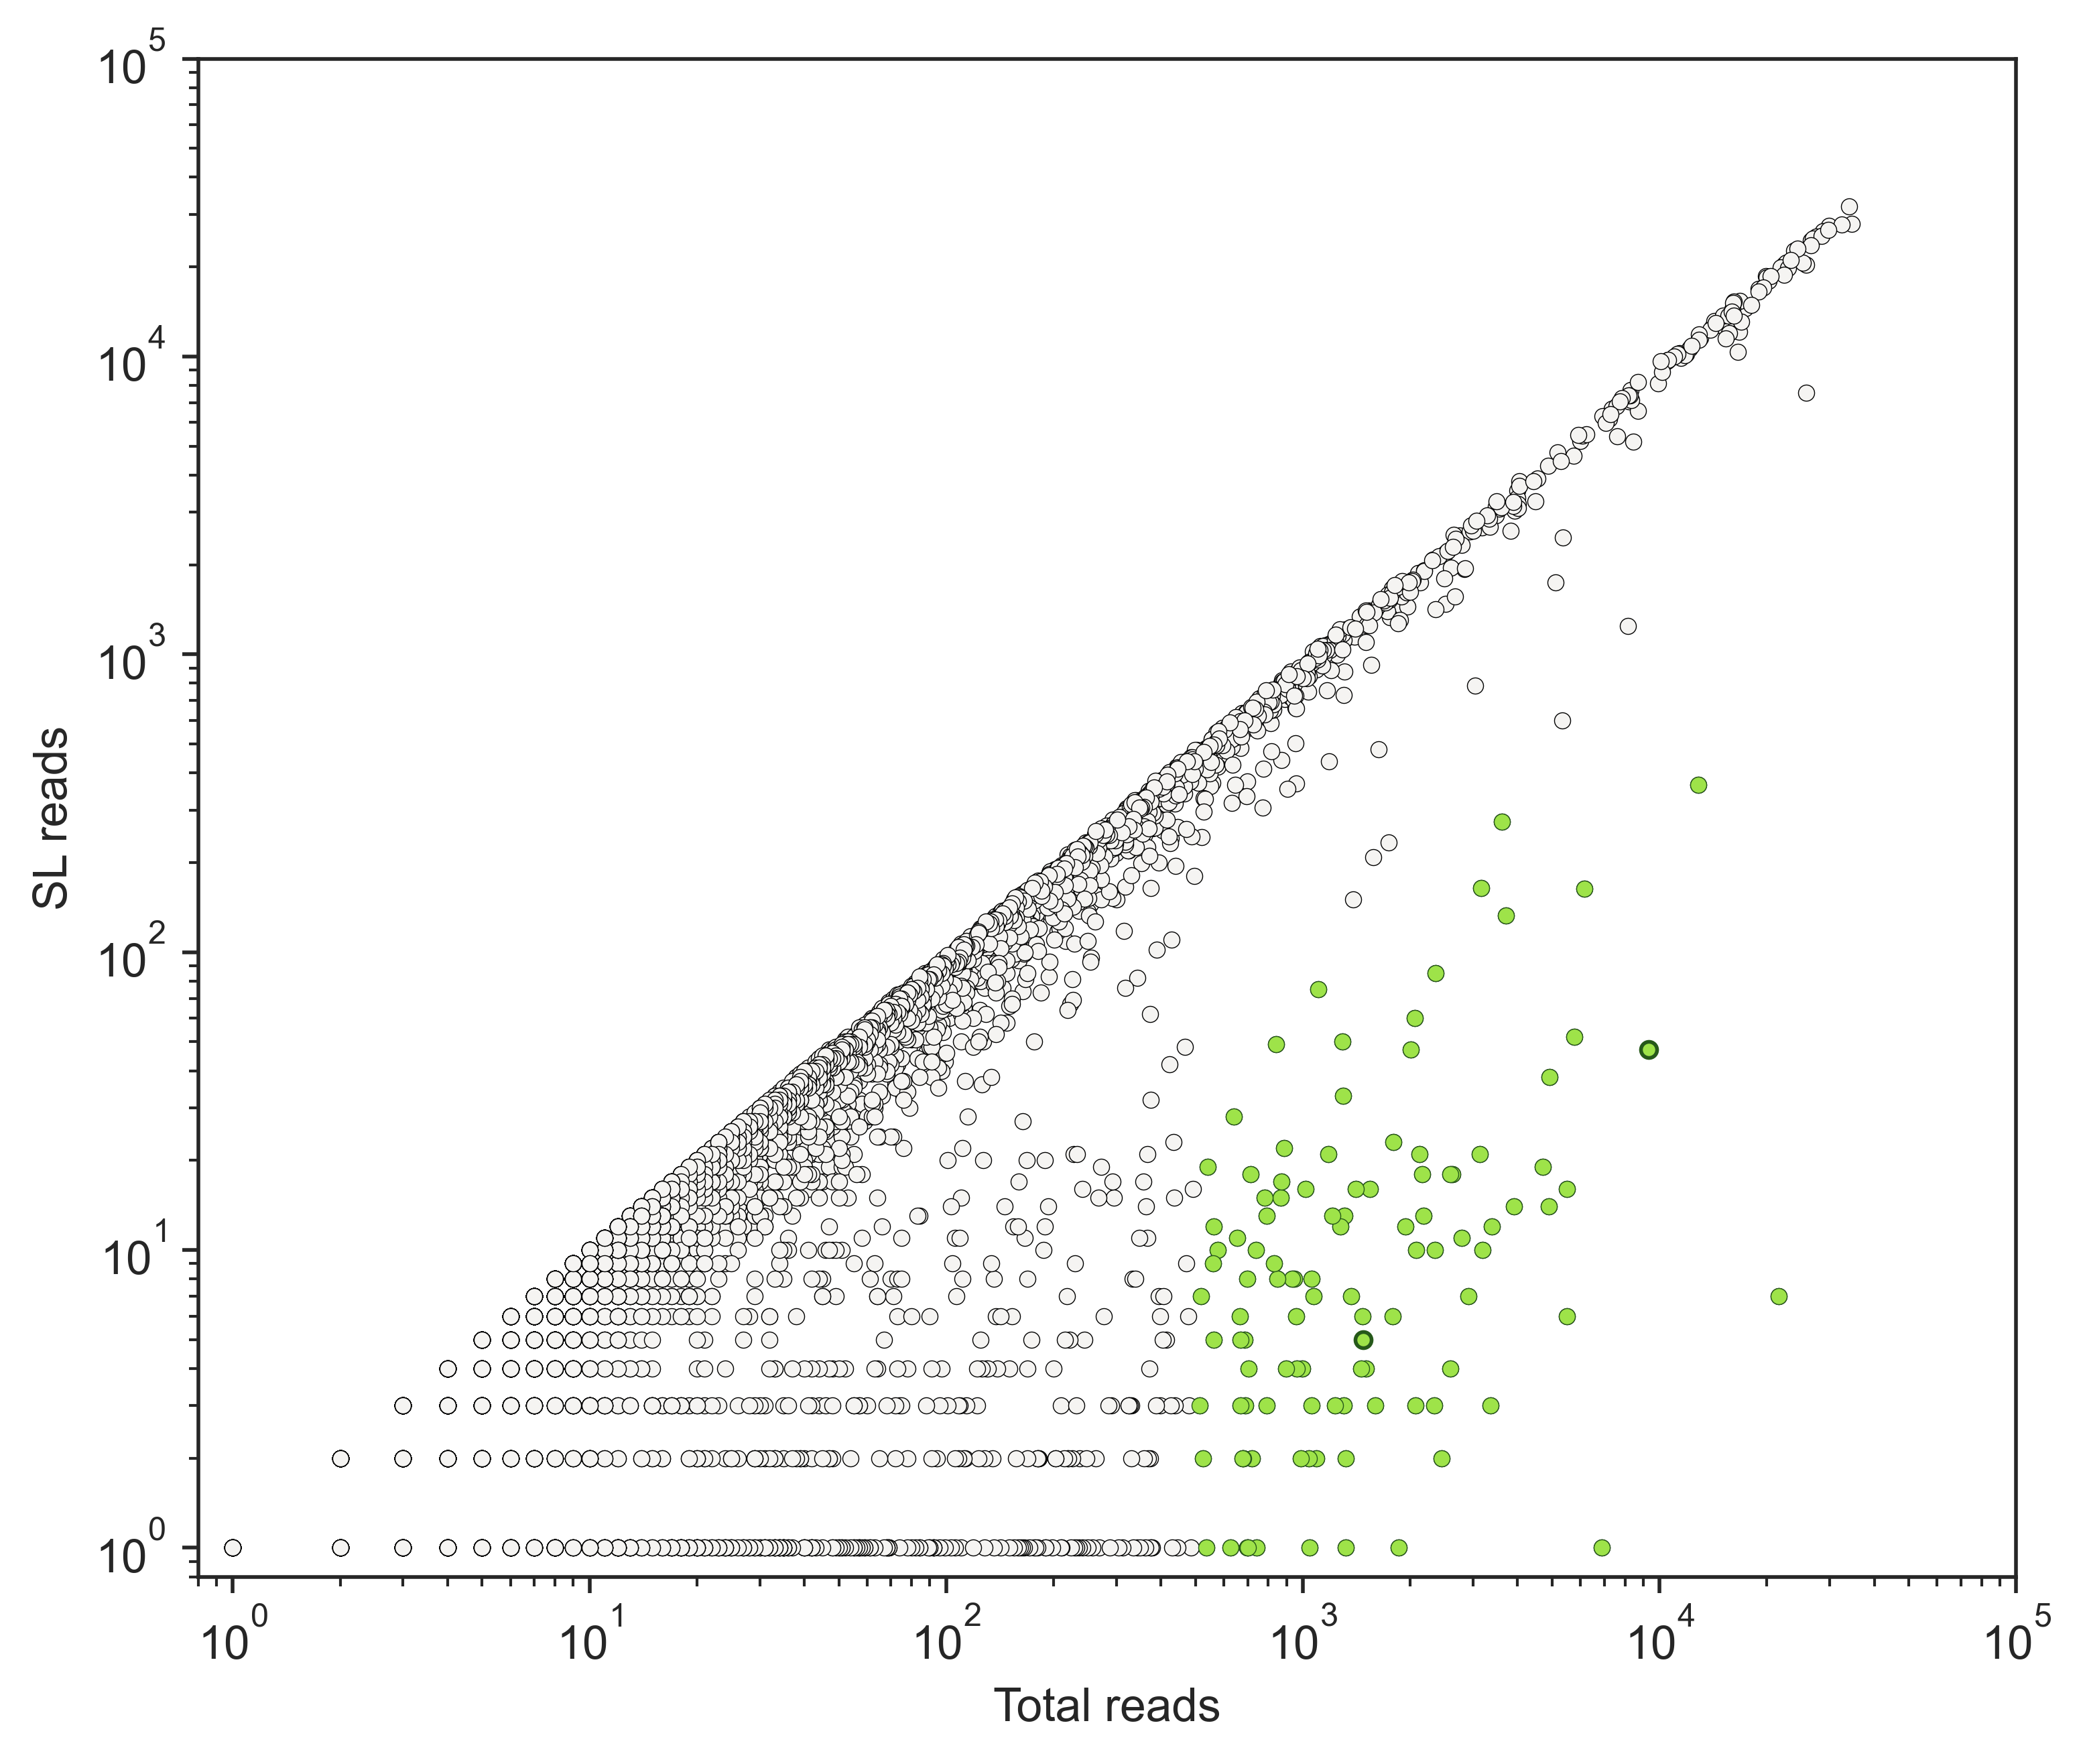

In [13]:
# for each, select the single most expressed position
most_exp_pos = genes_start.sort_values('total', ascending=False).groupby('gene').head(1)

# coordinates for every genes
x = list(most_exp_pos['evaluated'])
y = list(most_exp_pos['SL'])

# coordinates for genes with a position representated by 500+ reads and less than 10% SL 
selected = most_exp_pos[(most_exp_pos['evaluated']>=500) & (most_exp_pos['%SL']<=10)]
sx = list(selected['evaluated'])
sy = list(selected['SL'])

# Three genes of interest
ex = selected[selected['gene'].isin(['C42D8.2', 'F26F12.1', 'R12H7.2'])]
ex_x = list(ex['evaluated'])
ex_y = list(ex['SL'])

# Generate plot
%matplotlib inline

sns.set_style('ticks')
plt.figure(figsize=(7,6), dpi=500)

# plot all
plt.scatter(x, y, s=12, c='#f5f4f2', edgecolor='k', linewidth=0.2)

# plot selected
plt.scatter(sx, sy, s=12, c='#9ee349', edgecolor='#26591A', linewidth=0.2)

# plot examples
plt.scatter(ex_x, ex_y, s=12, c='#9ee349', edgecolor='#26591A', linewidth=0.8)


# plot settings
plt.xlabel('Total reads')
plt.ylabel('SL reads')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.8,10**5)
plt.ylim(0.8,10**5)

# save
plt.savefig('Fig4.b-trans-splicing_detection_level_at_main_start_positions.pdf', bbox_inches='tight', dpi=800)

<font size="4">**Figure 4.b:**<br></font>
Trans splicing detection level. For each gene we identified the most frequently detected 5’ alignment starting position and plotted the number of reads at this position vs the number of those reads that for which a splice Leader sequence could be detected. Genes for which the most represented start position had at least 100 reads but had less than 10% SL detection are represented in green.

<br>

# Panel c: 5’ stem loop structure

In [14]:
# Example of three genes presenting hairpin:

# vit-2 (C42D8.2)
# col-140 (F26F12.1)
# asp-4 (R12H7.2)

selected[selected['gene'].isin(['C42D8.2', 'F26F12.1', 'R12H7.2'])]

,gene,position,total,evaluated,SL,SL1,SL2,hairpin,unidentified,%SL,%hairpin,%unidentified,SL2_ratio
433239,F26F12.1,5836834,9333,9316,47,13,23,4767,4502,0.50,51.17,48.33,0.638889
226900,C42D8.2,5105432,1475,1475,5,2,3,683,787,0.34,46.31,53.36,0.600000
846279,R12H7.2,13221439,555,555,0,0,0,274,281,0.00,49.37,50.63,NaN


<font size="4">**Figure 4.c:**<br></font>
Poorly trans spliced mRNA have a propensity to form a 5’ stem loop structure (termed here as "hairpin").